In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.models import Model
import numpy as np

In [2]:
image_size = 224
num_classes = 2  # Bleeding and Non-Bleeding
patch_size = 7    # Based on your project requirement
projection_dim = 64
num_heads = 4
transformer_units = [projection_dim * 2, projection_dim]  # Transformer units
transformer_layers = 8  # Number of transformer layers

In [3]:
def MobileNetV2_base(input_shape):
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False  # Freeze the base model
    return base_model

In [4]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID"
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [5]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [6]:
from tensorflow.keras import layers as L

def mlp(x, hidden_units, dropout_rate):
    """Feed-forward network for the transformer block."""
    for units in hidden_units:
        x = L.Dense(units, activation=tf.nn.gelu)(x)
        x = L.Dropout(dropout_rate)(x)
    return x

def transformer_block(inputs, projection_dim, num_heads, transformer_units):
    """A single Transformer block with multi-head attention and MLP."""
    # Layer normalization 1.
    x1 = L.LayerNormalization(epsilon=1e-6)(inputs)

    # Multi-head attention.
    attention_output = L.MultiHeadAttention(
        num_heads=num_heads, key_dim=projection_dim, dropout=0.1
    )(x1, x1)

    # Skip connection 1.
    x2 = L.Add()([attention_output, inputs])

    # Layer normalization 2.
    x3 = L.LayerNormalization(epsilon=1e-6)(x2)

    # MLP.
    x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)

    # Skip connection 2.
    output = L.Add()([x3, x2])

    return output
def vision_transformer(image_size, patch_size, num_patches, projection_dim, 
                       num_heads, transformer_layers, transformer_units, mlp_head_units, n_classes):
    inputs = L.Input(shape=(image_size, image_size, 3))

    # Create patches.
    patches = Patches(patch_size)(inputs)

    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        encoded_patches = transformer_block(
            encoded_patches, projection_dim, num_heads, transformer_units
        )

    # Create a [batch_size, projection_dim] tensor.
    representation = L.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = L.Flatten()(representation)
    representation = L.Dropout(0.5)(representation)

    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)

    # Classify outputs.
    logits = L.Dense(n_classes, activation='softmax')(features)

    # Create the model.
    model = tf.keras.Model(inputs=inputs, outputs=logits)

    return model



In [7]:
from keras.layers import Input, Reshape, Dense, LayerNormalization, GlobalAveragePooling1D
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from keras.applications import MobileNetV2
from tensorflow.keras.layers import LayerNormalization, GlobalAveragePooling1D
from keras.models import Model
import numpy as np
class FourierTransformLayer(layers.Layer):
    def call(self, inputs):
        # Convert to complex64 for Fourier transformation
        fourier_features = tf.signal.fft2d(tf.cast(inputs, tf.complex64))
        # Take the magnitude to make it real-valued
        fourier_features = tf.math.abs(fourier_features)
        return fourier_features

def build_combined_model(image_size, patch_size, num_classes):
    # Feature extraction using MobileNetV2
    inputs = Input(shape=(image_size, image_size, 3))
    mobilenet = MobileNetV2(input_shape=(image_size, image_size, 3), include_top=False, weights='imagenet')
    mobilenet.trainable = False
    features = mobilenet(inputs)

    # Apply the custom Fourier transformation layer
    fourier_features = FourierTransformLayer()(features)

    # Reshape features for Vision Transformer
    feature_shape = fourier_features.shape[1:3]  # Height and width of the feature map after Fourier transform

    # Ensure feature shape is valid for patch extraction
    if feature_shape[0] % patch_size != 0:
        raise ValueError(f"Patch size {patch_size} does not divide feature height {feature_shape[0]}.")

    reshaped_features = Reshape((*feature_shape, fourier_features.shape[-1]))(fourier_features)
    # Calculate the number of patches
    num_patches = (feature_shape[0] // patch_size) ** 2
    print(f"Number of patches: {num_patches}")

    # Vision Transformer block
    patches = Patches(patch_size)(reshaped_features)
    encoded_patches = PatchEncoder(num_patches=num_patches, projection_dim=projection_dim)(patches)
    for _ in range(transformer_layers):
        encoded_patches = transformer_block(
            encoded_patches, projection_dim, num_heads, transformer_units
        )

    # Classification head
    representation = LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = GlobalAveragePooling1D()(representation)
    logits = Dense(num_classes, activation='softmax')(representation)

    # Create the model
    model = Model(inputs=inputs, outputs=logits)
    return model

# Build the model with Fourier transformation
model = build_combined_model(image_size=image_size, patch_size=patch_size, num_classes=num_classes)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Summary of the combined model
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Number of patches: 1


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_2… │ (None, 7, 7,      │  2,257,984 │ input_layer[0][0] │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fourier_transform_… │ (None, 7, 7,      │          0 │ mobilenetv2_1.00… │
│ (FourierTransformL… │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 7, 7,      │          0 │ fourier_transfor… │
│                     │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patches (Patches)   │ (None, None,      │          0 │ reshape[0][0]     │
│                     │ 62720)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_encoder       │ (None, None, 64)  │  4,014,208 │ patches[0][0]     │
│ (PatchEncoder)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, None, 64)  │        128 │ patch_encoder[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 64)  │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, None, 64)  │          0 │ multi_head_atten… │
│                     │                   │            │ patch_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 64)  │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, None, 128) │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, None, 128) │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, None, 64)  │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, None, 64)  │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, None, 64)  │          0 │ dropout_2[0][0],  │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 64)  │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 64)  │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, None, 64)  │          0 │ multi_head_atten… │
│                     │                   │            │ add_1[0][0]     

 Total params: 6,938,050 (26.47 MB)

 Trainable params: 4,680,066 (17.85 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [8]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Parameters
image_size = 224  # Define image size (adjust as necessary)
num_classes = 2  # For binary classification
batch_size = 16  # Common batch size for training

def load_data(data_dir, image_size):
    images = []
    labels = []
    
    for label in ['bleeding', 'non-bleeding']:
        folder_path = os.path.join(data_dir, label)
        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=(image_size, image_size))
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            images.append(img_array)
            labels.append(0 if label == 'bleeding' else 1)  # Assign labels accordingly

    images = np.array(images) / 255.0  # Normalize pixel values
    labels = np.array(labels)
    return images, labels

# Load your dataset
data_dir = '/kaggle/input/wce-dataset'  # Update with your dataset path
X, y = load_data(data_dir, image_size)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Data augmentation for training
data_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create a separate ImageDataGenerator for validation (without augmentation)
val_gen = ImageDataGenerator()

# Create data generators
train_generator = data_gen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_gen.flow(X_val, y_val, batch_size=batch_size)

# Ensure `build_combined_model` function is defined
model = build_combined_model(image_size=image_size, patch_size=7, num_classes=num_classes)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model using generators
epochs = 60  # Adjust number of epochs as needed
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, image_size, image_size, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.int32)
    )
).repeat()

val_dataset = tf.data.Dataset.from_generator(
    lambda: val_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, image_size, image_size, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.int32)
    )
).repeat()

# Train the model using datasets with steps_per_epoch and validation_steps
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    steps_per_epoch=len(X_train) // batch_size,
    validation_steps=len(X_val) // batch_size
)

# Evaluate the model
test_loss, test_acc = model.evaluate(val_dataset, steps=len(X_val) // batch_size)
print(f"Validation Loss: {test_loss}, Validation Accuracy: {test_acc}")


Number of patches: 1
Epoch 1/60


I0000 00:00:1730914723.669338     101 service.cc:145] XLA service 0x7feb7c01e700 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730914723.669403     101 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1730914723.669407     101 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1730914780.713586     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


130/130 ━━━━━━━━━━━━━━━━━━━━ 110s 212ms/step - accuracy: 0.5448 - loss: 1.0831 - val_accuracy: 0.5039 - val_loss: 0.6784
Epoch 2/60
130/130 ━━━━━━━━━━━━━━━━━━━━ 81s 203ms/step - accuracy: 0.6655 - loss: 0.6211 - val_accuracy: 0.7972 - val_loss: 0.5283
Epoch 3/60
130/130 ━━━━━━━━━━━━━━━━━━━━ 21s 161ms/step - accuracy: 0.7765 - loss: 0.4810 - val_accuracy: 0.7126 - val_loss: 0.5633
Epoch 4/60
130/130 ━━━━━━━━━━━━━━━━━━━━ 21s 159ms/step - accuracy: 0.8309 - loss: 0.3814 - val_accuracy: 0.9272 - val_loss: 0.2665
Epoch 5/60
130/130 ━━━━━━━━━━━━━━━━━━━━ 21s 161ms/step - accuracy: 0.8815 - loss: 0.3247 - val_accuracy: 0.9154 - val_loss: 0.1934
Epoch 6/60
130/130 ━━━━━━━━━━━━━━━━━━━━ 21s 162ms/step - accuracy: 0.8514 - loss: 0.3402 - val_accuracy: 0.7520 - val_loss: 0.4885
Epoch 7/60
130/130 ━━━━━━━━━━━━━━━━━━━━ 21s 161ms/step - accuracy: 0.8655 - loss: 0.3101 - val_accuracy: 0.9291 - val_loss: 0.2052
Epoch 8/60
130/130 ━━━━━━━━━━━━━━━━━━━━ 21s 161ms/step - accuracy: 0.9024 - loss: 0.2298 - va

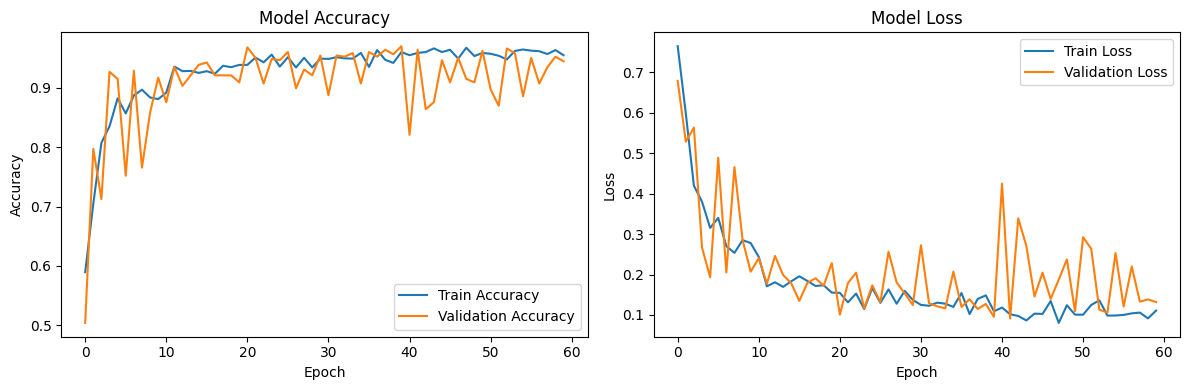

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [14]:
import numpy as np
from sklearn.metrics import cohen_kappa_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate the model
test_loss, test_acc = model.evaluate(val_dataset, steps=len(X_val) // batch_size)
print(f"Validation Loss: {test_loss}, Validation Accuracy: {test_acc}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9664 - loss: 0.1012
Validation Loss: 0.11200277507305145, Validation Accuracy: 0.960629940032959


82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step


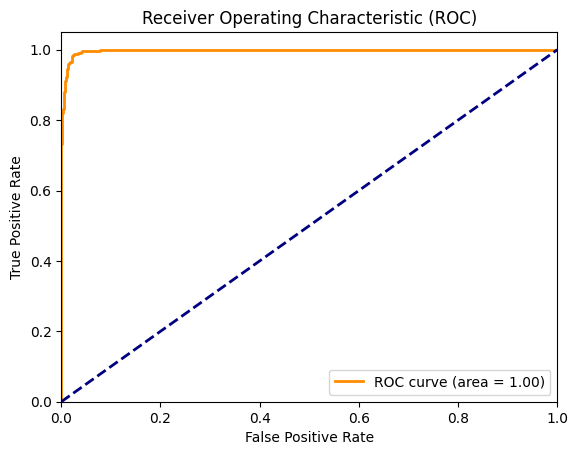

ROC AUC: 1.00
Specificity: 0.99
Sensitivity: 0.96
Precision: 0.99
Recall: 0.96
Cohen's Kappa: 0.94


In [23]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_curve, auc, cohen_kappa_score, confusion_matrix, precision_score, recall_score

# Set image size and batch size
batch_size = 32  # Ensure batch size matches the one used in training

# Predict on the validation dataset
y_pred_probs = model.predict(val_dataset, steps=len(val_dataset))  # Use exact steps based on `val_dataset`
y_true = np.concatenate([y for x, y in val_dataset], axis=0)  # True labels from validation set
y_pred = np.argmax(y_pred_probs, axis=1)  # Predicted classes

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_pred_probs[:, 1])  # Assume binary classification with probs for class 1
roc_auc = auc(fpr, tpr)

# Specificity, Sensitivity, Precision, and Recall
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

# Cohen's Kappa Score
cohen_kappa = cohen_kappa_score(y_true, y_pred)

# Plot ROC Curve
import matplotlib.pyplot as plt

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Print Metrics
print(f"ROC AUC: {roc_auc:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"Sensitivity: {sensitivity:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Cohen's Kappa: {cohen_kappa:.2f}")


/opt/conda/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step
Confusion Matrix:
 [[1290   19]
 [  56 1253]]


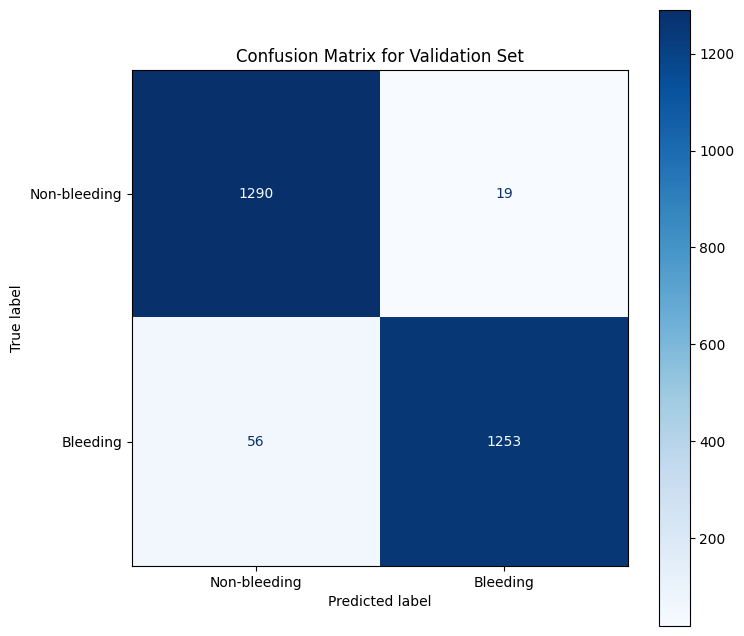


Classification Report:
               precision    recall  f1-score   support

Non-bleeding       0.96      0.99      0.97      1309
    Bleeding       0.99      0.96      0.97      1309

    accuracy                           0.97      2618
   macro avg       0.97      0.97      0.97      2618
weighted avg       0.97      0.97      0.97      2618



In [21]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# Predict on the validation dataset only
y_pred_probs = model.predict(X_val)  # Probability predictions on the validation set
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels

# Generate confusion matrix and classification report
cm = confusion_matrix(y_val, y_pred)
print("Confusion Matrix:\n", cm)

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-bleeding", "Bleeding"])
disp.plot(cmap="Blues", values_format="d", ax=plt.gca())
plt.title("Confusion Matrix for Validation Set")
plt.show()

# Additional classification report
report = classification_report(y_val, y_pred, target_names=["Non-bleeding", "Bleeding"])
print("\nClassification Report:\n", report)
